## Description

This sample Jupyter notebook is designed to demonstrate how easily analytic market data reports can be created with Monitor+. The Chart library used is Matplotlib. See the 'Imports' section below for a list of the other libraries used.

The report downloads two daily market data time series. The data is requested as business days (5 day week), filled forward with a common start date. The datasets are then converted to a Pandas data frame and 6 charts displaying both daily and non daily values (defined in the 'Global Variables' section below). 

This report is designed to be reused so the code down to section "Creating the Analytic Charts" can be reused for any report that requires two datasets. You simply need to change the datasource and symbol global variables to get different datasets. You can find the datasets easily in your Monitor+ Favorites list or when viewing a datasource metadata. You can  <a href="https://dev2.idatamedia.org/profilemain?tab=favorites"> click here</a> to log into your Monitor+ Favorites portal where you can manage your favorite datasets and datasources.  

The Analytic method used in this sample report is a very basic QQ (Quantile-Quantile) Plot. A QQ Plot is a probability plot for comparing two probability distributions by plotting their quantiles against each other. More details on QQ Plots can be found in a web search, at the <a href="https://towardsdatascience.com/q-q-plots-explained-5aa8495426c0">Towards Data Science</a> site or on <a href="https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot">Wikipedia</a>


<b>Disclaimer.</b><br>
We offer these reports for informational purposes only and are provided ‘as is’ without warranty of any kind, either express or implied, including, but not limited to, the implied warranties of fitness for a purpose, or the warranty of non-infringement.  Please refer to our <a href="https://www.idatamedia.org/terms-and-conditions">Terms and Conditions</a> for more information. Any links on this site are provided as a convenience and for informational purposes only; they do not constitute an endorsement or an approval by the us of any of the products, services or opinions of the corporation or organization or individual. We bear no responsibility for the accuracy, legality or content of the external site or for that of subsequent links. Contact any external sites for answers to questions regarding its content.  The market data used in the reports below may be generated sample data and as such not representative on any real or published values. Do not use any of the report values for any purpose other than to demonstrate the functionality of this report.



## Imports

In [5]:
#  IData is the Monitor+ class
from monitorplus import IData 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import warnings
warnings.filterwarnings('ignore')

## Global Variables

In [6]:
# Customers API Key needed to request for data from the Monitor+ API
#  You need to  change this API key to your own one.
API_KEY = "VOFWM-43RCS-PUH5T-A0X8I"

# Colors  https://i.stack.imgur.com/9UVnC.png
BOLD = '\033[01m'
RESET = '\033[0m'
BLUE_FG = '\033[34m'
BLACK_FG = '\033[30m'
GREEN_FG = '\033[32m'
WHITE_FG = '\033[37m'

RED_BG = '\033[101m'
GREEN_BG = '\033[42m'
# ANSI code Combinations used in labels
WARNING =  WHITE_FG + RED_BG
BLUE_LABEL = BOLD + BLUE_FG
NORMAL =  GREEN_FG 


#  number of rows to list in the  table outouts
Data_Rows=18

#  The full API documentation for getting the data is at:   
#       https://dev2.idatamedia.org/api-docs#getdatasetvaluesrc

# Sample Dataset #1 to use in the Notebook
API_Datasource1 = "ECBFX"
API_DSSymbol1 = "EURJPY"
# the Name below  will be filled from the API if the request is successful
API_DSName1 = ""

# Sample Dataset  #2 to use in the Notebook
API_Datasource2 = "ECBFX"
API_DSSymbol2 = "EURCAD"
# the Name below  will be filled from the API if the request is successful
API_DSName2 = ""

# The earliest date to request from the API
API_StartDate = "2010-01-01"

# Force common start date for both series
API_CommonStart=True

#  Fill the daily data before (prefill happens before calculating monthly averages)
API_Prefill=True

# Weekends can be added or removed by setting the value to "7"  or "5"
# "5" means only weekdays (no weekends) are returned. 
# Refer to th API documentation for many more options
API_WeekType = "5"


# API_PrefillType can be "previous",  "midpoint" or "interpolate"
API_PrefillType = "interpolate"

# We can choose to have 3 non-daily charts id any fqequency. 
# Valid simply Frequencies are: 
#  w, hm, m, q, hy  y 
# Check the API documentation "Frequency Parameter" and "Frequency Options" sections for examples of custom frequencies and weekend handling.
#      https://dev2.idatamedia.org/api-docs#getdatasetvaluesrc

NonDailyChartFreq = "m"
NonDailyChartFreqDesc = "monthly"

   

## API - Initialisation and return values for two datasets

The full list of theparameters used in the API request to get market data can be <a href="https://dev2.idatamedia.org/api-docs#getdatasetvaluesrc">viewed here</a>


In [7]:
# initialise the Python class
idata = IData()
# turn off comments from  Monitor+
idata.set_verbose(False)

RC_DayResult =  None

#Store the API Key in the Python Class
idata.set_api_key(API_KEY)

# We will return the metadata for the user favorite datasets
# Now request historical prices for two datasets in RC ( row x column) format.
RC_DayResult = idata.get_dataset_values_rc(
    Series=[
        # You can change the datasources and symbols in the Global Variable section above
        # For HandleWeekend parameters - see HandleWeekends section at the  "Viewed Here"  link above. 5a = 5 day adjusted.
        {"Datasource": API_Datasource1,"Symbol": API_DSSymbol1, "HandleWeekends":API_WeekType,"Fill":True, },
        {"Datasource": API_Datasource2,"Symbol": API_DSSymbol2, "HandleWeekends":API_WeekType,"Fill":True }
    ],
    # Additional API parameters
    StartDate = API_StartDate,
    CommonStart = API_CommonStart,
    Frequency = "d",
    Prefill = API_Prefill,
    # For missing valuess are filled
    FillOptions = {"Type": API_PrefillType},
     )
    
if (RC_DayResult is None):
       print (WARNING +'\n The RC_Result API call returned an error. \n' + RESET)
else:
    print ( NORMAL+ " The Daily API command was run successfully. \n")



 The Daily API command was run successfully. 



# Display daily data in a table.

In [9]:
#Access the Monitor+ utility file that helps us to process the report data.
#from monitorplus_utils import MonitorUtils
from IPython.display import display

API_DSName1Day = ""
API_DSName2Day = ""

# Check we have data from the 'API Initialisation' section above using its RC_Result variable
if (RC_DayResult is None):
    print ('\033[1m' +'\nThe  API request for daily data failed. Please check the "API Initialisation" section above.' + '\033[0m')   
else:
    # Extract the names for the datasets.  We can use them later to check if the extract was successful.
    API_DSName1Day, API_DSName2Day = RC_DayResult["Columns"][0]['Name'], RC_DayResult["Columns"][1]['Name']
    
    #  Check datasets are loaded OK
    if API_DSName2Day > "":
        mu = MonitorUtils(API_DSName1Day, API_DSName2Day)
        df = mu.get_display_data(RC_DayResult)
        # show the latest elements in a table - rows defined in global Data_Rows variable
        print("\n\nThe latest "+str(Data_Rows)+" daily data rows:\n")
  
        display(df.tail(Data_Rows))
        
        # The methods we use require our data to be a Time-Series. 
        df["Date"] = pd.to_datetime(df["Date"])
        df.set_index("Date", inplace=True)   
    else:
        print(WARNING + '\n Dataset number 2 was not returned from the Monitor+ Utils class. ' + RESET)


NameError: name 'MonitorUtils' is not defined

# Request the non-daily data.


In [5]:
# The frequency used is defined in the "lobal Variables" section at the top of the page  in variable  'NonDailyChartFreq'
# set success flag
RC_NDResult =  None


# Check we have data from the 'API Initialisation' section above using its RC_Result variable
if (RC_DayResult is None):
    print ('\033[1m' +'\nThe  API request for daily data failed. Please check the "API Initialisation" section above.' + '\033[0m')   
else:
    # Now request historical non-daily prices for two datasets in RC (row x column) format.
    RC_NDResult = idata.get_dataset_values_rc(
    Series=[

        # You can change the datasources and symbols in the Global Variable section above
        # For HandleWeekend parameters - see HandleWeekends section at the  "Viewed Here"  link above. 5a = 5 day adjusted.
        {"Datasource": API_Datasource1,"Symbol": API_DSSymbol1, "HandleWeekends":API_WeekType,"Fill":True, },
        {"Datasource": API_Datasource2,"Symbol": API_DSSymbol2, "HandleWeekends":API_WeekType,"Fill":True }
         ],
    # Additional API parameters
    StartDate = API_StartDate,
    Frequency = NonDailyChartFreq,
    CommonStart = API_CommonStart,
    Prefill = API_Prefill,
    FillOptions = {"Type": API_PrefillType},
    )

if (RC_NDResult is None):
       print (WARNING +'\n The "+NonDailyChartFreqDesc+" API call returned an error. \n' + RESET)
else:
    print ( NORMAL+ " The "+NonDailyChartFreqDesc+" API command was run successfully. \n")


 The monthly API command was run successfully. 



# Display the non-daily data in a table.

In [6]:
# Check we have data from the "Get non-daily data" section above using its RC_NDResult variable
if (RC_NDResult is None):
    print ('\033[1m' +'\nThe non-daily API request failed. Please check the "Get non-daily data" section above.' + '\033[0m')   
else:
    # Extract the names for the datasets.  We can use them later to check if the extract was successful.
    API_DSName1ND, API_DSName2ND = RC_NDResult["Columns"][0]['Name'], RC_NDResult["Columns"][1]['Name']
    
    #  Check datasets are loaded OK
    if API_DSName2ND > "":
        mu = MonitorUtils(API_DSName1ND, API_DSName2ND)
        df_ND = mu.get_display_data(RC_NDResult)
        print("\n\nThe latest "+str(Data_Rows)+" "+NonDailyChartFreqDesc+" data rows:\n")
        # show the latest elements in a table - rows defined in global Data_Rows variable
        display(df_ND.tail(Data_Rows))
        
        # The methods we use require our data to be a Time-Series. 
        df_ND["Date"] = pd.to_datetime(df_ND["Date"])
        df_ND.set_index("Date", inplace=True)   
    else:
        print(WARNING + '\n Dataset number 2 was not returned from the Monitor+ Utils class. ' + RESET)



The latest 18 monthly data rows:



,Date,Year,Month,ECB - Euro vs Japanese Yen,ECB - Euro vs Canadian Dollar
113,2019-06-28,2019,6,121.292,1.491
114,2019-07-31,2019,7,122.024,1.480
115,2019-08-30,2019,8,117.111,1.463
116,2019-09-30,2019,9,118.308,1.449
117,2019-10-31,2019,10,119.165,1.448
118,2019-11-29,2019,11,119.700,1.455
119,2019-12-31,2019,12,121.527,1.467
120,2020-01-31,2020,1,120.069,1.437
121,2020-02-28,2020,2,121.145,1.462
122,2020-03-31,2020,3,116.213,1.507


# Creating the Daily Charts.

Plotting the two daily API datasets as daily charts.

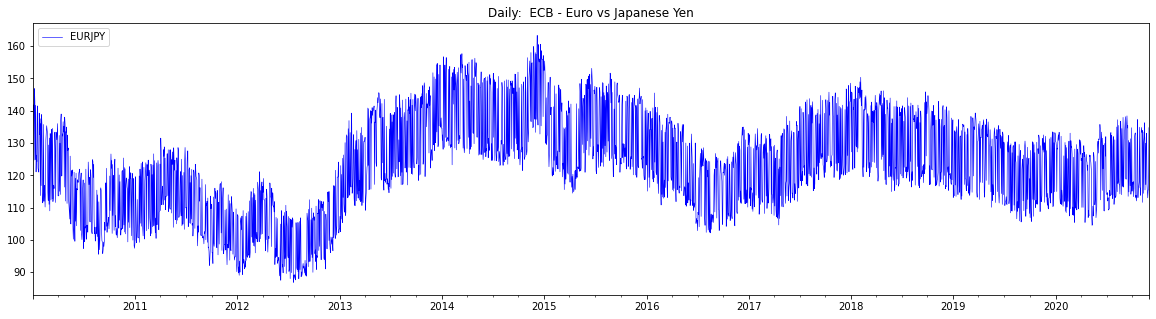

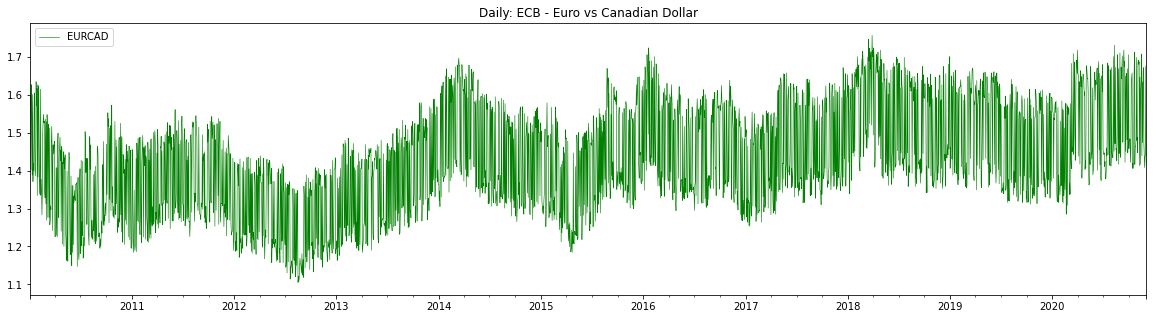

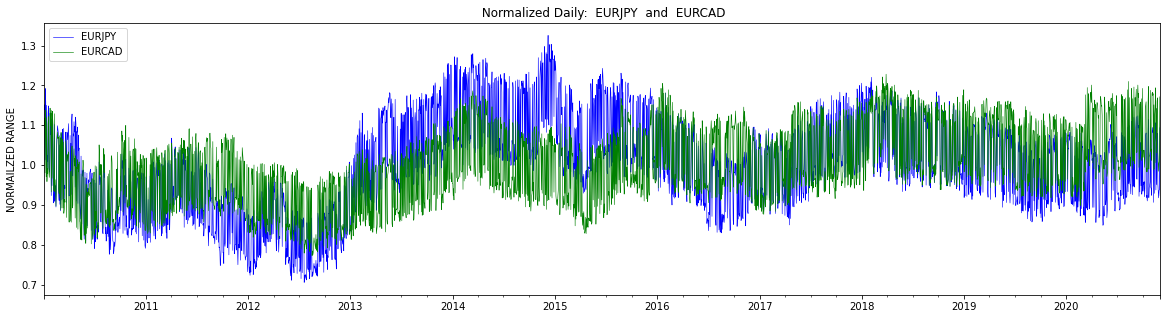



Creating the monthly average charts. 


In [7]:
#  Check datasets are loaded in case code is run out of sequence
if API_DSName2Day > "":
    df[API_DSName1Day].plot(figsize=(20,5), title = API_DSName1Day,  color = 'blue',  linewidth=.6,  label=API_DSSymbol1)
    plt.title(f"Daily:  {API_DSName1Day}")
    plt.legend(loc='upper left')
    ax = plt.subplot()
    ax.set_xlabel('')
    plt.show()
 
    df[API_DSName2Day].plot(figsize=(20,5), title = API_DSName2Day, color = 'green', linewidth=.6,   label=API_DSSymbol2)
    plt.title(f"Daily: {API_DSName2Day}")
    plt.legend(loc='upper left')
    ax = plt.subplot()
    ax.set_xlabel('')
    plt.show()
    
    # We normalize the datasets to a common range to show them overlaid. We use the "mean" to calculate the average
    df[API_DSName1Day].div(df[API_DSName1Day].mean()).plot(figsize=(20,5), title = API_DSName1Day, color = 'blue',linewidth=.6, label=API_DSSymbol1)
    df[API_DSName2Day].div(df[API_DSName2Day].mean()).plot(figsize=(20,5), title = API_DSName2Day,  linestyle = 'solid', color = 'green',linewidth=.6, label=API_DSSymbol2)
    plt.title("Both Series")
    plt.title(f" Normalized Daily:  {API_DSSymbol1}  and  {API_DSSymbol2}")
    plt.legend(loc='upper left')
    ax = plt.subplot()
    ax.set_xlabel('')
    ax.set_ylabel('NORMAILZED RANGE')    
    plt.show()    
    print( BLUE_LABEL + '\n\nCreating the '+NonDailyChartFreqDesc+' average charts. ' + RESET)
else:
    print(WARNING + '\n\n Daily Chart: No dataset was loaded from the API for series number 2. ' + RESET)



# Creating the non-daily Charts.

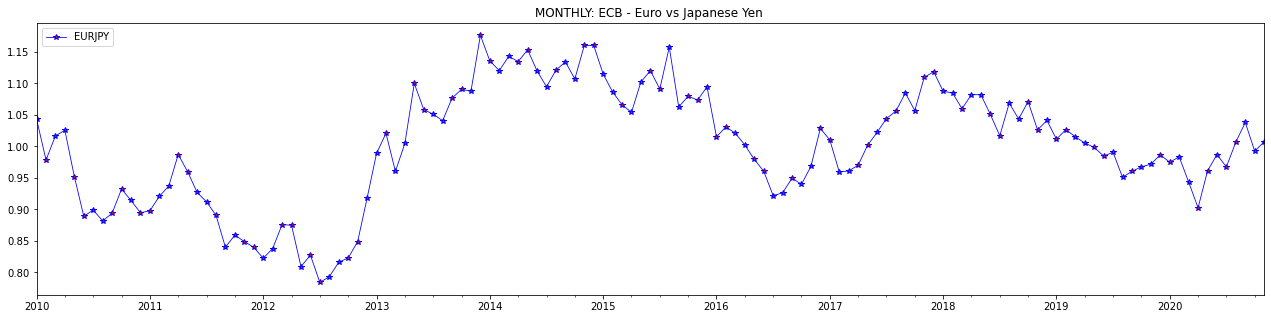

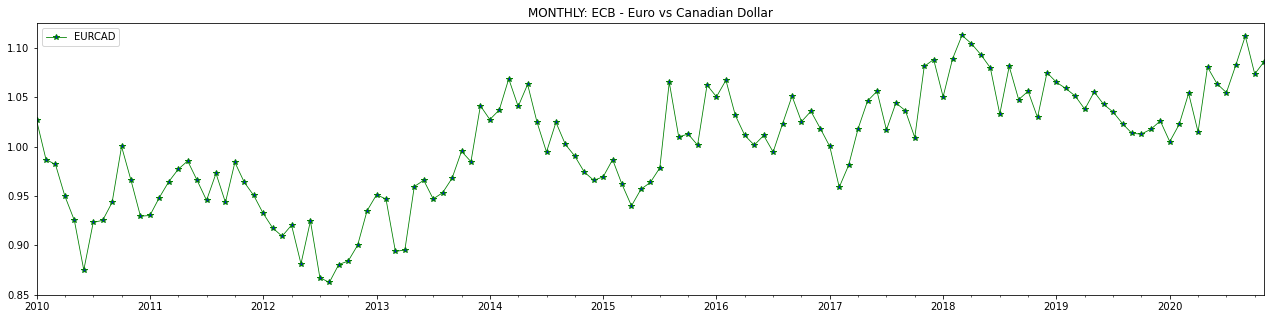

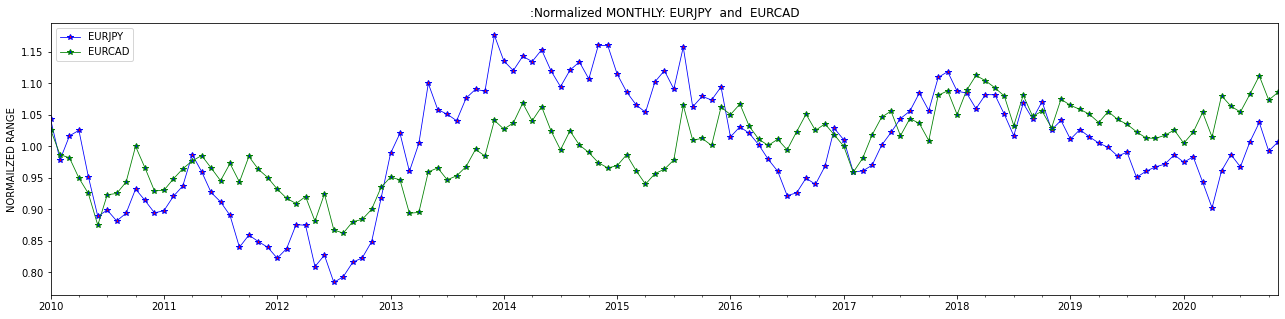

In [8]:
#  Check datasets are loaded


if (API_DSName2Day > "")  and (RC_NDResult is not None):
    df_ND[API_DSName1ND].div(df_ND[API_DSName1ND].mean()).plot(figsize=(22,5), title = API_DSName1ND, marker = '*', color = 'blue', markerfacecolor = 'r', linewidth=.8,   label=API_DSSymbol1)
    plt.title(f"{NonDailyChartFreqDesc.upper()}: {API_DSName1ND} ")
    plt.legend(loc='upper left')
    ax = plt.subplot()
    ax.set_xlabel('')
    plt.show()    
    
    df_ND[API_DSName2ND].div(df_ND[API_DSName2ND].mean()).plot(figsize=(22,5), title = API_DSName2ND, marker = '*', color = 'green', markerfacecolor = 'b', linewidth=.8, label=API_DSSymbol2)
    plt.title(f"{NonDailyChartFreqDesc.upper()}: {API_DSName2ND}")
    plt.legend(loc='upper left')
    ax = plt.subplot()
    ax.set_xlabel('')
    plt.show()    
    
    df_ND[API_DSName1ND].div(df_ND[API_DSName1ND].mean()).plot(figsize=(22,5), title = API_DSName1ND,marker = '*', color = 'blue', markerfacecolor = 'r', linewidth=.8,   label=API_DSSymbol1)
    df_ND[API_DSName2ND].div(df_ND[API_DSName2ND].mean()).plot(figsize=(22,5), title = API_DSName2ND,marker = '*', color = 'green', markerfacecolor = 'b', linewidth=.8, label=API_DSSymbol2)
    plt.title(f":Normalized {NonDailyChartFreqDesc.upper()}: {API_DSSymbol1}  and  {API_DSSymbol2}")
    plt.legend(loc='upper left')
    ax = plt.subplot()
    ax.set_xlabel('')
    ax.set_ylabel('NORMAILZED RANGE')
    plt.show() 
else:
    print(WARNING + '\n'+NonDailyChartFreqDesc.upper()+' Charts: Non-daily data is not available for series #2 ('+API_DSName2Day+').' + RESET)


## Forescating with SARIMA


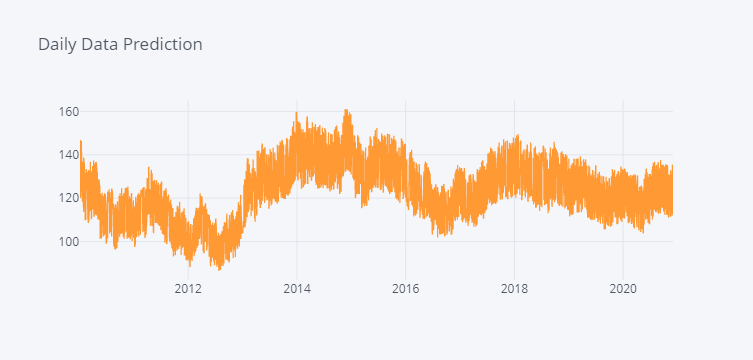

In [27]:
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')
df[API_DSName1Day].iplot(title="Daily Data Prediction")

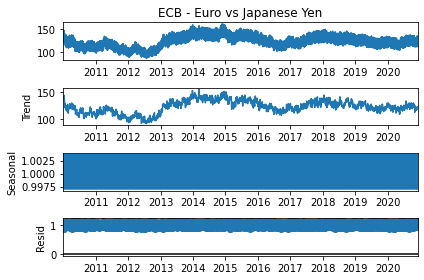

In [29]:
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
from chart_studio.plotly import plot_mpl
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df[API_DSName1Day], model='multiplicative')
fig = result.plot()
#plot_mpl(fig)
fig.show()

## Performing the SARIMA

In [40]:
#from pyramid.arima import auto_arima; the pyramid namespace is deprecated and has migrated to pmdarima
from pmdarima import auto_arima
stepwise_model = auto_arima(df[API_DSName1Day], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=9.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=24683.567, Time=0.46 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=23040.449, Time=1.43 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.81 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=23886.029, Time=0.35 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=22725.798, Time=4.76 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=18.24 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.13 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=23534.827, Time=1.71 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=22412.968, Time=3.36 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=22739.257, Time=1.95 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=34.19 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.93 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=22245.293, Time=41.82 sec
 ARIMA(3,1,0)(1,1,0)[12]             :

In [101]:
train = df[API_DSName1Day].loc['2010-01-01':'2019-12-01']
test = df[API_DSName1Day].loc['2020-01-01':]
#test.reset_index(drop=True, inplace=True)
print(test.index)

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-13', '2020-01-14',
               ...
               '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-23',
               '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27',
               '2020-11-30', '2020-12-01'],
              dtype='datetime64[ns]', name='Date', length=240, freq=None)


In [80]:
stepwise_model.fit(train)

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [122]:
future_forecast = stepwise_model.predict(n_periods=test.shape[0], dynamic=True)
# This returns an array of predictions:
print(future_forecast.shape)

(240,)


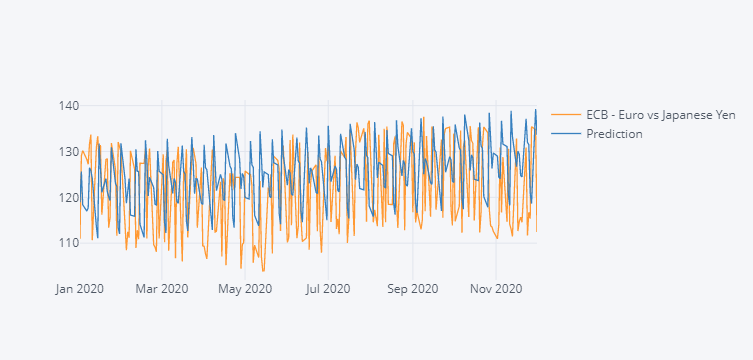

In [124]:
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=['Prediction'])
#future_forecast.reset_index(drop=True, inplace=True)
#future_forecast.shape
#future_forecast
#test.shape
#test, future_forecast
df1 = pd.concat([test, future_forecast], axis=1)
df1.iplot()
#future_forecast.iplot()
#test.iplot()

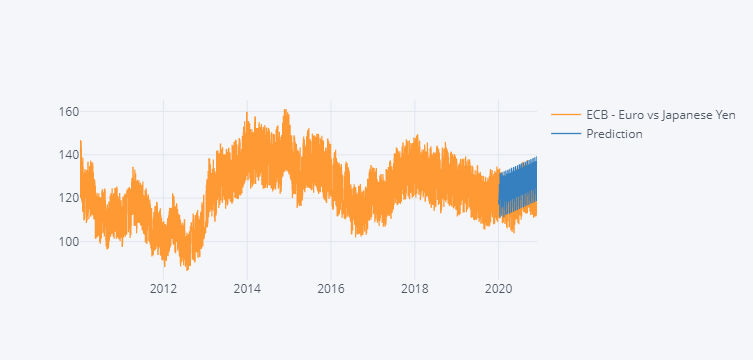

In [125]:
pd.concat([df[API_DSName1Day], future_forecast], axis=1).iplot()